# DCGan with skorch

Code is adapted from [pytorch examples](https://github.com/pytorch/examples/tree/master/dcgan)

## Imports

In [1]:
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

In [3]:
from skorch import NeuralNet
from skorch.utils import to_tensor
from skorch.callbacks import PassthroughScoring

## Parameters

In [4]:
torch.manual_seed(0)
device = torch.device("cuda:0") if torch.cuda.is_available() else 'cpu'

In [5]:
nz = 100  # size of the latent z vector
ngf = 32  # units of generator
ndf = 32  # units of discriminator
nc = 1  # number of channels
batch_size = 64
lr = 0.0002
beta1 = 0.5  # for adam
max_epochs = 5
ngpu = 1
img_size = 32  # 32 is easier than 28 to work with
workers = 2  # for dataloader

In [6]:
path = './mnist'

## Load data

In [7]:
dataset = dset.MNIST(
    root=path,
    download=True,
    transform=transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]),
)

## Custom code

In [8]:
# custom weights initialization called on generator and discriminator
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [9]:
class Generator(nn.Module):
    def __init__(self, nz, ngf, ngpu):
        super().__init__()
        self.nz = nz
        self.ngf = ngf
        self.ngpu = ngpu

        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 4 x 4
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 8 x 8
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 16 x 16
            nn.ConvTranspose2d(ngf,     nc, 4, 2, 1, bias=False),
            nn.Tanh(),
            # state size. (nc) x 32 x 32
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output

In [10]:
class Discriminator(nn.Module):
    def __init__(self, nc, ndf, ngpu):
        super().__init__()
        self.nc = nc
        self.ndf = ndf
        self.ngpu = ngpu

        self.main = nn.Sequential(
            # state size. (ndf) x 32 x 32
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)

In [11]:
class Dcgan(nn.Module):
    def __init__(self, nc, nz, ndf, ngf, ngpu):
        super().__init__()
        
        self.nc = nc
        self.nz = nz
        self.ndf = ndf
        self.ngf = ngf
        self.ngpu = ngpu

        self.discriminator = Discriminator(
            nc=self.nc,
            ndf=self.ndf,
            ngpu=self.ngpu,
        )
        self.discriminator.apply(weights_init)
        self.generator = Generator(
            nz=self.nz,
            ngf=self.ngf,
            ngpu=self.ngpu,
        )
        self.discriminator.apply(weights_init)
        
    def forward(self, X, y=None):
        # general forward method just returns fake images
        return self.generator(X)

In [12]:
class DcganNet(NeuralNet):
    def __init__(self, *args, optimizer_gen, optimizer_dis, **kwargs):
        self.optimizer_gen = optimizer_gen
        self.optimizer_dis = optimizer_dis
        super().__init__(*args, **kwargs)

    def initialize_optimizer(self, *_, **__):
        args, kwargs = self.get_params_for_optimizer(
            'optimizer_gen', self.module_.generator.named_parameters())
        self.optimizer_gen_ = self.optimizer_gen(*args, **kwargs)

        args, kwargs = self.get_params_for_optimizer(
            'optimizer_dis', self.module_.discriminator.named_parameters())
        self.optimizer_dis_ = self.optimizer_dis(*args, **kwargs)

        return self
    
    def validation_step(self, Xi, yi, **fit_params):
        raise NotImplementedError
    
    def train_step(self, Xi, yi=None, **fit_params):
        Xi = to_tensor(Xi, device=self.device)
        discriminator = self.module_.discriminator
        generator = self.module_.generator
        label_real = torch.ones((len(Xi),),device=self.device)
        label_fake = torch.zeros((len(Xi),),device=self.device)

        # (1) Update discriminator: maximize log(D(x)) + log(1 - D(G(z)))
        discriminator.zero_grad()
        output_real = discriminator(Xi)
        loss_real = self.criterion_(output_real, label_real)
        loss_real.backward()

        noise = torch.randn(Xi.shape[0], self.module_.nz, 1, 1, device=self.device)
        fake = generator(noise)
        output_fake = discriminator(fake.detach())
        loss_fake = self.criterion_(output_fake, label_fake)
        loss_fake.backward()
        
        self.optimizer_dis_.step()
        
        # (2) Update generator: maximize log(D(G(z)))
        generator.zero_grad()
        output_fake = discriminator(fake)
        loss_gen = self.criterion_(output_fake, label_real)
        loss_gen.backward()
        self.optimizer_gen_.step()
        
        loss_dis = loss_real + loss_fake
        
        self.history.record_batch('loss_dis', loss_dis.item())
        self.history.record_batch('loss_gen', loss_gen.item())
        
        return {
            'y_pred': fake,
            'loss': loss_dis + loss_gen,
        }

In [13]:
net = DcganNet(
    Dcgan,
    module__nz=nz,
    module__ndf=ndf,
    module__ngf=ngf,
    module__nc=nc,
    module__ngpu=ngpu,
    
    criterion=nn.BCELoss,

    optimizer_gen=optim.Adam,
    optimizer_gen__lr=0.0002,
    optimizer_gen__betas=(beta1, 0.999),

    optimizer_dis=optim.Adam,
    optimizer_dis__lr=0.00002,
    optimizer_dis__betas=(beta1, 0.999),

    batch_size=batch_size,
    max_epochs=max_epochs,

    train_split=False,  # not implemented
    iterator_train__shuffle=True,
    iterator_train__num_workers=workers,
    iterator_valid__num_workers=workers,

    callbacks=[
        PassthroughScoring('loss_dis', on_train=True),
        PassthroughScoring('loss_gen', on_train=True),
    ],
)

## Train net

In [14]:
net.set_params(optimizer_gen__lr=0.0003, optimizer_dis__lr=0.0004)

<class '__main__.DcganNet'>[uninitialized](
  module=<class '__main__.Dcgan'>,
  module_=Dcgan(
    (discriminator): Discriminator(
      (main): Sequential(
        (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): LeakyReLU(negative_slope=0.2, inplace=True)
        (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): LeakyReLU(negative_slope=0.2, inplace=True)
        (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (7): LeakyReLU(negative_slope=0.2, inplace=True)
        (8): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
        (9): Sigmoid()
      )
    )
    (generator): Generator(
      (main): Sequential(
        (0): ConvTranspose2d(100, 128, kernel

In [15]:
#net.fit(torch.utils.data.Subset(dataset, torch.arange(0, 500)))
net.fit(dataset)

  epoch    loss_dis    loss_gen    train_loss       dur
-------  ----------  ----------  ------------  --------
      1      0.4713      3.2007        3.6720  288.9744
      2      0.4876      2.8905        3.3781  363.5930
      3      0.3492      3.6009        3.9501  300.6626
      4      0.3198      3.7600        4.0798  297.8958
      5      0.1154      5.0819        5.1972  293.7685


<class '__main__.DcganNet'>[initialized](
  module_=Dcgan(
    (discriminator): Discriminator(
      (main): Sequential(
        (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): LeakyReLU(negative_slope=0.2, inplace=True)
        (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): LeakyReLU(negative_slope=0.2, inplace=True)
        (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (7): LeakyReLU(negative_slope=0.2, inplace=True)
        (8): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
        (9): Sigmoid()
      )
    )
    (generator): Generator(
      (main): Sequential(
        (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=Fal

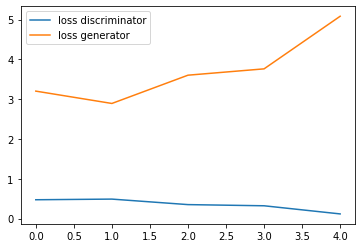

In [16]:
plt.plot(net.history[:, 'loss_dis'], label='loss discriminator')
plt.plot(net.history[:, 'loss_gen'], label='loss generator')
plt.legend()

## Inspect images

In [17]:
noise = torch.randn(10, nz, 1, 1)

In [18]:
fakes = net.predict(noise)

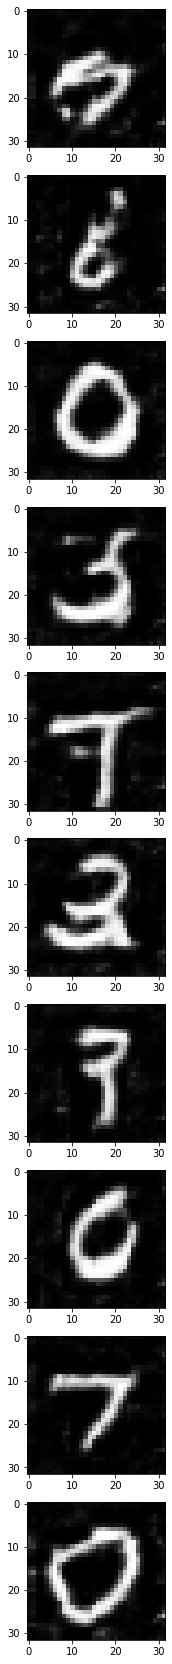

In [19]:
_, axes = plt.subplots(10, 1, figsize=(8, 30))
for i in range(10):
    axes[i].imshow(fakes[i][0], cmap='gray')